#**Задача. Определение стоимости автомобилей на вторичном рынке**

## **Постановка задачи**:
**Цель:** Разработать модель предсказания стоимости автомобиля на вторичном рынке. В ходе работы вы пройдёте все основные этапы полноценного исследования.

**Источник данных:** kaggle

**Целевой признак:** *sellingprice* — стоимость автомобиля

**Метрика оценки качества:** *MAPE*.


## **Описание проекта:**

### **Данные**
- *train.csv* - информация о характеристиках автомобилей (440000), которые будут использоваться в качестве обучающих данных.
- *sample_submission.csv* - пример файла предсказаний в правильном формате.
- *vin* - идентификатор автомобиля в тестовом наборе.
- *sellingprice* - Целевой признак. Для каждого автомобиля предскажите числовое значение стоимости продажи.

#### **Описание полей данных**
- *Date*: Год выпуска автомобиля.
- *Make*: Марка автомобиля.
- *Model*: издание автомобиля определенной марки.
- *Trim*: Уровни отделки салона автомобиля — это просто разные версии модели.
- *Body*: Тип кузова транспортного средства относится к форме и модели конкретной марки автомобиля.
- *Transmission*: механизм, который передает мощность от двигателя к колесам.
- *VIN*: идентификационный номер транспортного средства.
- *State*: состояние, в котором автомобиль выставлен на аукцион.
- *Condition*: Состояние автомобилей на момент аукциона.
- *Odometer*: расстояние, пройденное автомобилем с момента выпуска.
- *Color*: Цвет кузова автомобиля.
- *Interior*: Цвет салона автомобиля.
- *Seller*: Продавец автомобиля, автосалоны.
- *mmr*: Рекорд рынка Manhiem, рыночная оценочная цена автомобилей.
- *sellingprice*: цена, по которой автомобиль был продан на аукционе.
- *saledate*: Дата продажи автомобиля.

###**Алгоритм решения:**
  1. Загрузка данных.
   - Предварительное изучение данных.
   - Отчистка от явно лишней информации.
   - Формирование общего датасета для дальнейшего исследование и предобработки.
  2. Предобработка данных:
    - Работа с аномалиями, пропусками и дубликатами.
    - формирования датасета для анализа.
  3. Анализ данных и подготовка для построения математической модели:
    - Непосредственно анализ.
    - Удаление неинформативных признаков, генерация ряда признаков, по необходимости.
    - Разделение общего датасета на выборки для обучения и проверки модели.
    - Кодирование и масштабирование признаков - стандартизация данных, по необходимости.
  6. Построение и обучение математической модели:
    - Описание моделей
    - Предварительная проверка моделей
    - Линейная регрессия,Lasso.
    - DecisionTreeRegressor
    - Light GBMRegressor,
    - CatBoostRegressor,
    - XGBRegressor.
  7. Выбор лучшей модели. Тестирование.
  8. Выводы.

## Загрузка и предварительное исследование данных

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump
import math
import time
import re
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.metrics import make_scorer, mean_absolute_percentage_error, mean_absolute_error,  mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from numpy.random import RandomState
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

#проект запускаю в colab
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    !pip install catboost
    !pip install ipywidgets
    !jupyter nbextension enable --py widgetsnbextension

    print('Environment: Google Colab')

!"{sys.executable}" -m pip install phik
import phik
from phik.report import plot_correlation_matrix
from phik import report
from catboost import CatBoostRegressor
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

In [ ]:
#!pip install vininfo
#from vininfo import Vin
!pip install pyvin
from pyvin import VIN
from tqdm import tqdm

In [ ]:
#если данные храняться на googledisk, подключаем его
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')
try:
    data_train=pd.read_csv('/content/drive/MyDrive/kaggle/data/train.csv', sep=',') #, index_col=[0], parse_dates=[0]
    data_test=pd.read_csv('/content/drive/MyDrive/kaggle/data/test.csv', sep=',')#, index_col=[0], parse_dates=[0]
    data_sample=pd.read_csv('/content/drive/MyDrive/kaggle/data/sample_submission.csv', sep=',')#, index_col=[0], parse_dates=[0]
except:
    data_train=pd.read_csv('/content/train.csv', sep=',', index_col=[0])
    data_test=pd.read_csv('/content/test.csv', sep=',', index_col=[0])
    data_sample=pd.read_csv('/content/sample_submission.csv', sep=',', index_col=[0])

In [ ]:
# Приведем все даенные в читаемый формат
#pd.options.display.float_format = '{:,.1f}'.format
def express_info(data, name):
    print(f'Информация {name}:')
    data.info()
    display(data.head(3))
    print()

In [ ]:
express_info(data_train, 'train датасет')
express_info(data_test, 'test датасет')
express_info(data_sample, 'sample датасет')

Информация train датасет:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB


,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)



Информация test датасет:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          110058 non-null  int64  
 1   make          107997 non-null  object 
 2   model         107979 non-null  object 
 3   trim          107944 non-null  object 
 4   body          107464 non-null  object 
 5   transmission  97047 non-null   object 
 6   vin           110058 non-null  object 
 7   state         110058 non-null  object 
 8   condition     107679 non-null  float64
 9   odometer      110039 non-null  float64
 10  color         109900 non-null  object 
 11  interior      109900 non-null  object 
 12  seller        110058 non-null  object 
 13  saledate      110058 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 11.8+ MB


,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,Wed Jan 14 2015 04:30:00 GMT-0800 (PST)
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,Fri Feb 27 2015 01:00:00 GMT-0800 (PST)
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,Tue Feb 24 2015 01:30:00 GMT-0800 (PST)



Информация sample датасет:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vin           110058 non-null  object 
 1   sellingprice  110058 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.7+ MB


,vin,sellingprice
0,1g6dp567450124779,13592.209588
1,1gtw7fca7e1902207,13592.209588
2,jn8az1mw6dw303497,13592.209588


In [ ]:
#напишем функцию для исследования данных
def research(data, name, figsize, silent):
    print(f'Размер данных:      {data.shape}')
    print(f'Количество явных дубликатов: {data.duplicated().sum()}')
    print(f'Наличие пропусков:           {data.isna().sum().sum()}')
    print('Пропущенные данные (в процентном соотношении):')
    import logging
    logging.getLogger('matplotlib.font_manager').disabled = True
    print(round(data.isna().mean()*100).sort_values(ascending=False).head(15))
    #data.info()
    if not silent:
        print(f'\nПроверка структуры {name}:')
        data.hist(linewidth=2, histtype='step', figsize=figsize)
        plt.suptitle(f'Гистограмма распеределения {name}', y=0.95, fontsize=12)
        plt.show()

        print()
        #тепловая карта корреляций
        plt.figure(figsize=figsize)
        matrix = np.triu(data.corr())
        heatmap = sns.heatmap(data.corr(), annot=True, fmt='.2g',
                          mask=matrix, square=True,
                          cmap='Pastel1',  cbar=False,
                          xticklabels=True, yticklabels=True , vmin=0, vmax=1, center= 0)#'coolwarm', cmap=cmap,
        plt.suptitle(f'Тепловая карта матрицы корреляции {name}', y=0.91, fontsize=12)
        plt.show()
        print()
        display(data.describe())
#    if silent:
#        print(f'Корреляция {name}')
#        display(data.corr().round(3)\
#                .style\
#                .background_gradient(cmap='Pastel2', low= 0, high = 1, axis = 0, subset = None))
    display(data.head(5))

Размер данных:      (440236, 15)
Количество явных дубликатов: 0
Наличие пропусков:           97003
Пропущенные данные (в процентном соотношении):
transmission    12.0
make             2.0
model            2.0
trim             2.0
body             2.0
condition        2.0
year             0.0
vin              0.0
state            0.0
odometer         0.0
color            0.0
interior         0.0
seller           0.0
sellingprice     0.0
saledate         0.0
dtype: float64

Проверка структуры train данныe:


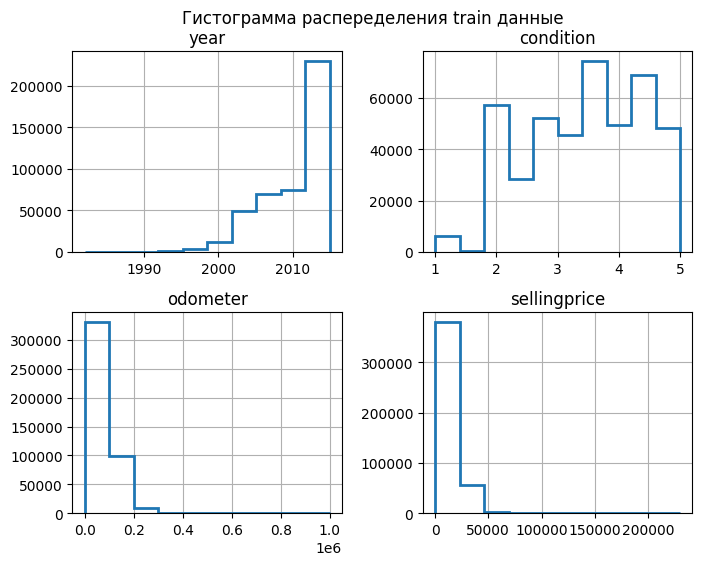

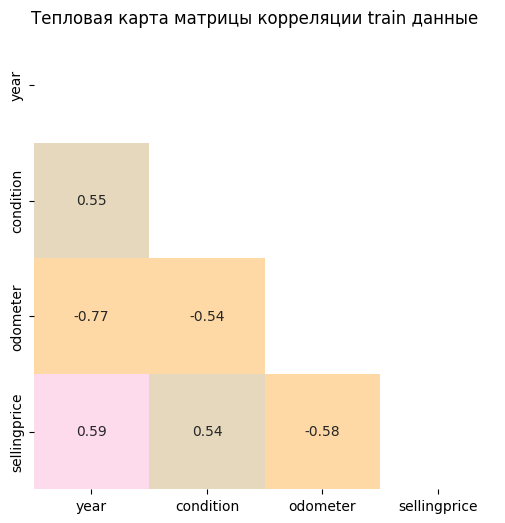

,year,condition,odometer,sellingprice
count,440236.000000,430831.000000,440167.000000,440236.000000
mean,2010.040101,3.425077,68344.421604,13592.209588
std,3.977945,0.949973,53542.203908,9751.479098
min,1982.000000,1.000000,1.000000,1.000000
25%,2007.000000,2.700000,28258.000000,6900.000000
50%,2012.000000,3.600000,52098.000000,12100.000000
75%,2013.000000,4.200000,99272.000000,18200.000000
max,2015.000000,5.000000,999999.000000,230000.000000


,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)
3,2003,HUMMER,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,Tue Feb 03 2015 04:00:00 GMT-0800 (PST)


Размер данных:      (110058, 14)
Количество явных дубликатов: 0
Наличие пропусков:           24573
Пропущенные данные (в процентном соотношении):
transmission    12.0
make             2.0
model            2.0
trim             2.0
body             2.0
condition        2.0
year             0.0
vin              0.0
state            0.0
odometer         0.0
color            0.0
interior         0.0
seller           0.0
saledate         0.0
dtype: float64

Проверка структуры test данныe:


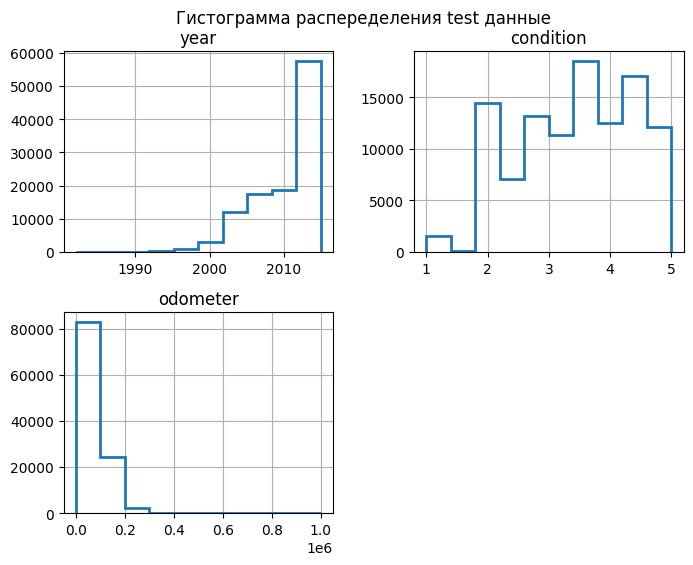

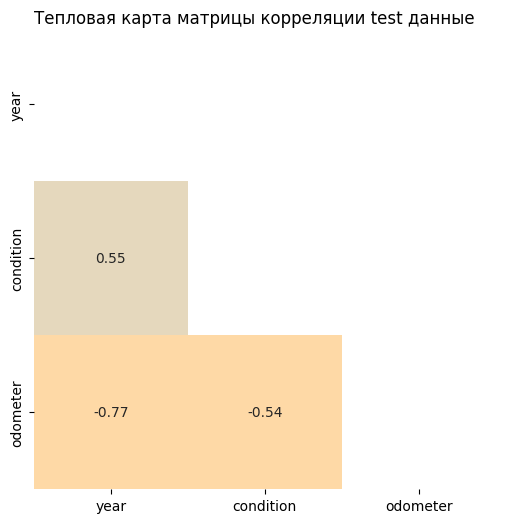

,year,condition,odometer
count,110058.000000,107679.000000,110039.000000
mean,2010.060005,3.423222,68074.331601
std,3.960190,0.951301,53520.988173
min,1982.000000,1.000000,1.000000
25%,2007.000000,2.700000,28313.500000
50%,2012.000000,3.600000,51922.000000
75%,2013.000000,4.200000,98852.500000
max,2015.000000,5.000000,999999.000000


,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,Wed Jan 14 2015 04:30:00 GMT-0800 (PST)
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,Fri Feb 27 2015 01:00:00 GMT-0800 (PST)
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,Tue Feb 24 2015 01:30:00 GMT-0800 (PST)
3,2013,Chevrolet,Impala,LS Fleet,Sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,Fri Mar 06 2015 02:00:00 GMT-0800 (PST)
4,2013,Nissan,Titan,SV,Crew Cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,black,black,nissan north america inc.,Wed Jun 03 2015 03:30:00 GMT-0700 (PDT)


In [ ]:
research(data_train, "train данныe", figsize=(8, 6), silent=False)
research(data_test, "test данныe", figsize=(8, 6), silent=False)

In [ ]:
data_train['trim'].unique() #.sort_values()

array(['SEL', 'SE', '2.0 SL', ..., '2.5 X L.L.Bean Edition',
       '3500 High Roof 140 WB', '4x4 v6 xlt sport'], dtype=object)

In [ ]:
#cat_col = ['make', 'model', 'trim', 'body', 'transmission','color','interior']
data_train.columns

Index(['year', 'make', 'model', 'trim', 'body', 'transmission', 'vin', 'state',
       'condition', 'odometer', 'color', 'interior', 'seller', 'sellingprice',
       'saledate'],
      dtype='object')

Предварительные выводы:
- пропуски в основном transmission(12%), make(2%), model(2%), trim(2%), body(2%), condition(2%), проверим данные более детально.
- transmission(12%)
- можно удалить неинформативные дня нас признаки: 'seller'.
- приведем в удобный формат 'saledate'.
- проверим на уникальность значения в столбцах, для начала понизим регистр.
- один из вариантов заполнения пропусков make(2%)и model(2%) - распарсить VIN.

## **2. Предобработка данных.**

### Исследование данных

In [ ]:
#Напишем функцию предобработки данных
def transform(data, name_row):
    data[name_row] = data[name_row].str.upper()
    data=data.drop(['seller'], axis=1)
    return data

In [ ]:
data_train = transform(data_train, 'vin')
data_train.head(3)
data_test = transform(data_test, 'vin')
data_test.head(3)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,saledate
0,2005,Cadillac,CTS,Base,Sedan,automatic,1G6DP567450124779,ca,2.7,116970.0,silver,black,Wed Jan 14 2015 04:30:00 GMT-0800 (PST)
1,2014,GMC,Savana Cargo,2500,Van,NaN,1GTW7FCA7E1902207,pa,4.4,6286.0,white,gray,Fri Feb 27 2015 01:00:00 GMT-0800 (PST)
2,2013,Nissan,Murano,S,SUV,automatic,JN8AZ1MW6DW303497,oh,4.6,11831.0,gray,black,Tue Feb 24 2015 01:30:00 GMT-0800 (PST)


In [ ]:
#сохраним копию дата сета
data_train1=data_train.copy()
data_test1=data_test.copy()
#data_train.to_csv('data_train_model.csv', index=False)

In [ ]:
#research(data_test1, "данных об автомобилях", figsize=(8, 6), silent=True)

In [ ]:
data_train1.info()
research(data_train1, "данных об автомобилях", figsize=(8, 6), silent=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  sellingprice  440236 non-null  int64  
 13  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(10)
memory usage: 47.0+ MB
Размер данных:      (440236, 14)
Количество явных дубликатов: 0
Наличие пропусков:           97003
Пропущенные данные (в 

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2FMDK3JC4BBA41556,md,4.2,111041.0,black,black,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3FA6P0H75ER208976,mo,3.5,31034.0,black,black,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3N1AB6AP4CL698412,nj,2.2,35619.0,black,black,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)
3,2003,HUMMER,H2,Base,suv,automatic,5GRGN23U93H101360,tx,2.8,131301.0,gold,beige,13300,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
4,2007,Ford,Fusion,SEL,Sedan,automatic,3FAHP08Z17R268380,md,2.0,127709.0,black,black,1300,Tue Feb 03 2015 04:00:00 GMT-0800 (PST)


In [ ]:
#data5['sellingprice'] = pd.to_numeric(data5['sellingprice'], errors='coerce').round().astype('int16')
#data5['room'] = pd.to_numeric(data5['room'], errors='coerce').round().astype('int16')
#data5['s_total_m2'] = pd.to_numeric(data5['s_total_m2'], errors='coerce').round().astype('float16')
#data5['s_live_m2'] = pd.to_numeric(data5['s_live_m2'], errors='coerce').round().astype('float16')
#data5['s_kitchen_m2'] = pd.to_numeric(data5['s_kitchen_m2'], errors='coerce').round().astype('float64')

In [ ]:
#напишем функцию для изучения данных в столбцах
def feed_size(data, state, name_state): #, x_lim0, x_lim
    print(f'Статистические данные о распределении значений {name_state} ({state}):')
    display(data[f'{state}'].describe())

    plt.subplots(figsize=(12, 1))
    #plt.xlim([x_lim0, x_lim])
    plt.title(f'Диаграмма рассеяния {name_state} ({state})')
    sns.boxplot(x=data[f'{state}'], palette='pastel', data=data[f'{state}'])
    plt.show()

    plt.figure(figsize=(12, 2))
    #sns.kdeplot(data[f'{state}'], fill=True, label=f'{state} {name_state}', alpha=0.6, shade=True)
    sns.histplot(data[f'{state}'], color="seagreen", label=f'{name_state}', alpha=0.7, kde=True)
    #plt.xlim([x_lim0, x_lim])
    plt.xlabel(f'{state}')
    plt.ylabel(f'Распределение вероятности \nнепрерывной величины')
    plt.legend(loc='upper right')
    plt.title(f'Гистограмма распределения {name_state} ({state})', fontsize=12)
    plt.show()

#### Рассмотрим данные целевого признака **`sellingprice`**

Статистические данные о распределении значений общая стоимость (sellingprice):


count    440236.000000
mean      13592.209588
std        9751.479098
min           1.000000
25%        6900.000000
50%       12100.000000
75%       18200.000000
max      230000.000000
Name: sellingprice, dtype: float64

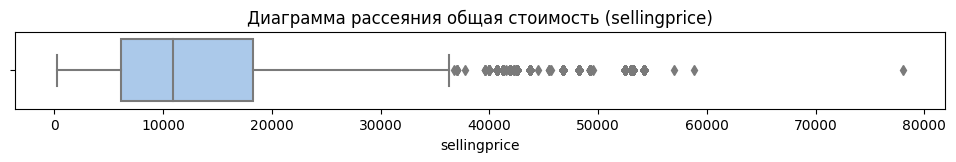

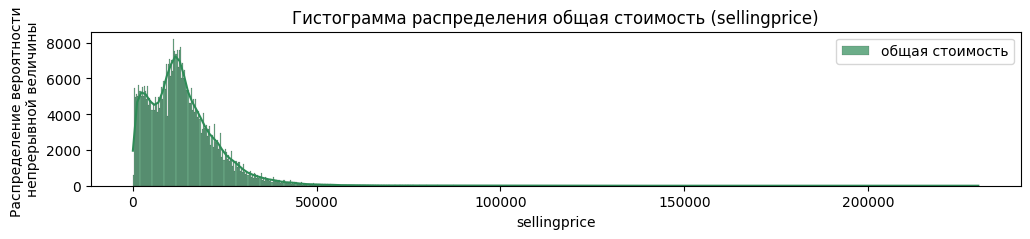

In [ ]:
feed_size(data_train1, 'sellingprice', 'общая стоимость')#, 250

- распределений вроде бы нормальное, но наблюдается два явных пика, будем в будущем ориентироваться на них при заполнении
- также наблюдаются выбросы по цене от **50000**, отнесем эти данные к категории **`lux`**

In [ ]:
#проверим данные аномальныx выбросов
#data_train1[data_train1['sellingprice']==230000]
data_train1[data_train1['sellingprice']>=50000].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2765 entries, 133 to 439680
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          2765 non-null   int64  
 1   make          2722 non-null   object 
 2   model         2652 non-null   object 
 3   trim          2722 non-null   object 
 4   body          2716 non-null   object 
 5   transmission  2394 non-null   object 
 6   vin           2765 non-null   object 
 7   state         2765 non-null   object 
 8   condition     2757 non-null   float64
 9   odometer      2765 non-null   float64
 10  color         2722 non-null   object 
 11  interior      2722 non-null   object 
 12  seller        2765 non-null   object 
 13  sellingprice  2765 non-null   int64  
 14  saledate      2765 non-null   object 
dtypes: float64(2), int64(2), object(11)
memory usage: 345.6+ KB


In [ ]:
data_lux=data_train1[data_train1['sellingprice']>=50000]
data_lux.describe()

,year,condition,odometer,sellingprice
count,2765.000000,2757.000000,2765.000000,2765.000000
mean,2013.261483,4.363475,15922.744304,65273.612297
std,1.619789,0.549651,12443.626818,18286.911980
min,2005.000000,1.900000,4.000000,50000.000000
25%,2013.000000,4.100000,6594.000000,53500.000000
50%,2014.000000,4.400000,13205.000000,59000.000000
75%,2014.000000,4.800000,21927.000000,71000.000000
max,2015.000000,5.000000,93858.000000,230000.000000


#### Рассмотрим данные признака **`condition`**

Статистические данные о распределении значений состояния автомобиля (condition):


count    430831.000000
mean          3.425077
std           0.949973
min           1.000000
25%           2.700000
50%           3.600000
75%           4.200000
max           5.000000
Name: condition, dtype: float64

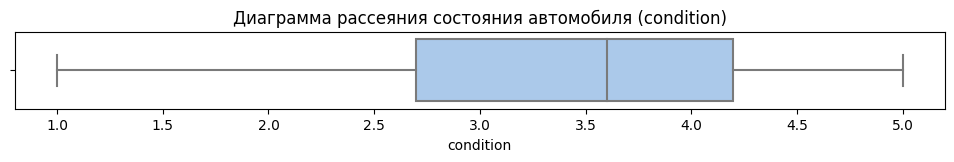

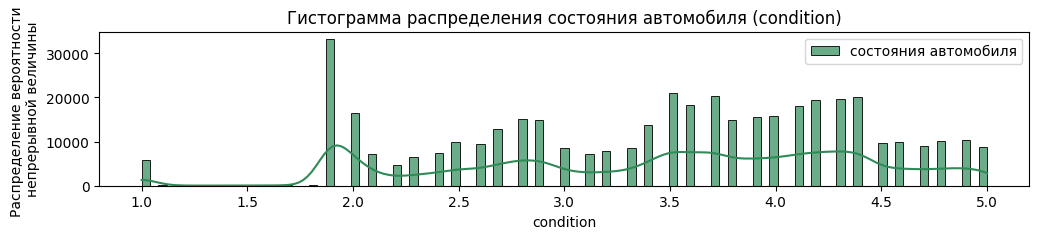

In [ ]:
feed_size(data_train1, 'condition', 'состояния автомобиля')#, 250

#### Рассмотрим данные признака **`odometer`**

In [ ]:
#feed_size(data_test1, 'odometer', 'пробега автомобиля')

Статистические данные о распределении значений пробега автомобиля (odometer):


count    440167.000000
mean      68344.421604
std       53542.203908
min           1.000000
25%       28258.000000
50%       52098.000000
75%       99272.000000
max      999999.000000
Name: odometer, dtype: float64

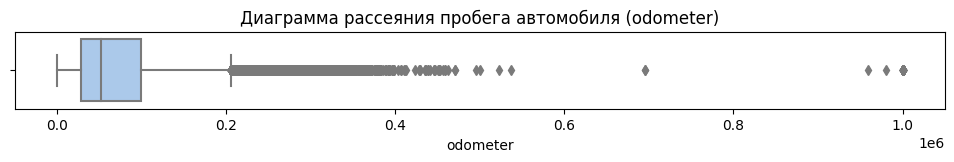

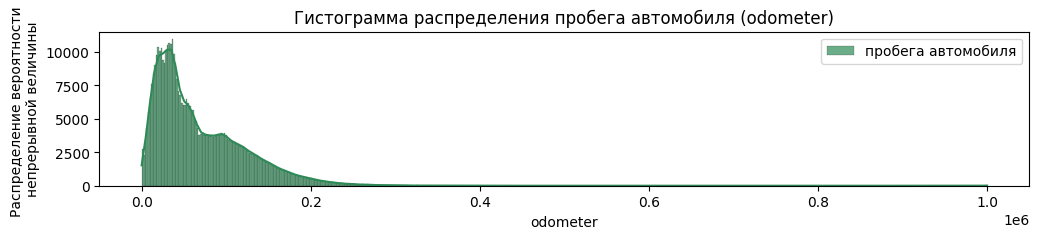

In [ ]:
feed_size(data_train1, 'odometer', 'пробега автомобиля')#, 250
#feed_size(data_test1, 'odometer', 'пробега автомобиля')

In [ ]:
data_train1[data_train1['odometer']==999999].head(3)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,sellingprice,saledate
6069,2012,Hyundai,Sonata,GLS,Sedan,automatic,5NPEB4AC6CH429831,oh,1.0,999999.0,white,gray,800,Tue Jan 06 2015 05:00:00 GMT-0800 (PST)
11122,2004,Chevrolet,Tahoe,LS,SUV,automatic,1GNEC13V34J247109,ga,1.9,999999.0,black,tan,1800,Tue Jan 06 2015 01:30:00 GMT-0800 (PST)
12368,2006,Mazda,Tribute,i,SUV,automatic,4F2YZ02Z26KM30632,fl,2.0,999999.0,white,tan,1200,Mon Feb 09 2015 01:30:00 GMT-0800 (PST)


#### Рассмотрим данные признака **`year`**

Статистические данные о распределении значений год производства (year):


count    440236.000000
mean       2010.040101
std           3.977945
min        1982.000000
25%        2007.000000
50%        2012.000000
75%        2013.000000
max        2015.000000
Name: year, dtype: float64

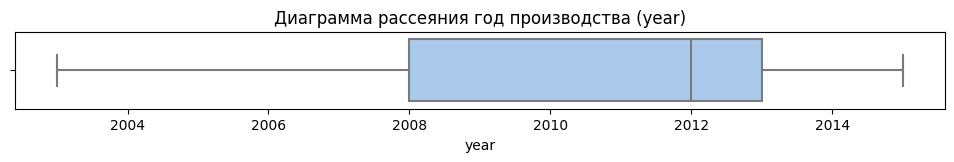

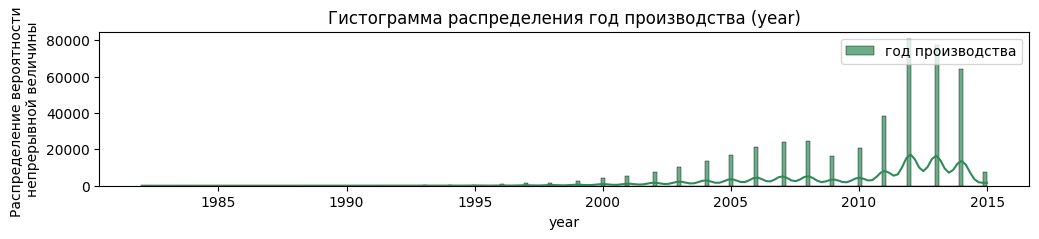

In [ ]:
feed_size(data_train1, 'year', 'год производства')
#feed_size(data_test1, 'year', 'пробега автомобиля')

Видно, что в основном в продаже автомобили от 2011 до 2014 гг

#### **`saledate`**

In [ ]:
#переведем колонку с датой в формат даты
data_train1['saledate'] = pd.to_datetime(data_train1['saledate'], infer_datetime_format=True)
data_test1['saledate'] = pd.to_datetime(data_test1['saledate'], infer_datetime_format=True)
data_train1.sample(2)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
393875,2011,Ford,F-150,XLT,SuperCrew,automatic,1ftfw1et8bfc66979,co,4.2,60576.0,white,gray,direct financial solutions inc,20900,2014-12-23 11:45:00+08:00
302528,2007,Kia,Spectra,EX,Sedan,automatic,knafe121175466814,tx,2.9,135187.0,gold,tan,city loan,1600,2015-01-27 03:00:00+08:00


In [ ]:
data_time = data_train1.filter(['saledate', 'year', 'sellingprice']).set_index('saledate')
data_time.index = pd.to_datetime(data_time.index, utc=True)
data_time.sample(5)

,year,sellingprice
saledate,,
2015-02-24 18:30:00+00:00,2011,17000
2014-12-18 10:30:00+00:00,2001,450
2015-02-04 17:50:00+00:00,2007,5800
2015-06-02 19:30:00+00:00,2013,19300
2015-01-21 20:00:00+00:00,2011,6900


<Axes: xlabel='saledate'>

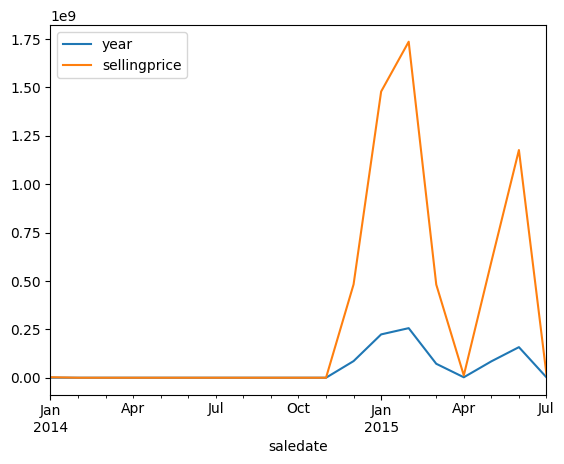

In [ ]:
data_time_s = data_time.resample('1M').sum()
data_time_s.plot()

Наблюдаются явные пики продаж в январе и в июне - учтем эту особенность при создании признаков.

In [ ]:
data_time['year_sale'] = data_time.index.year
data_time['month_sale'] = data_time.index.month
data_time.head(3)

,year,sellingprice,year_sale,month_sale
saledate,,,,
2015-06-01 19:30:00+00:00,2011,12500,2015,6
2015-02-24 18:00:00+00:00,2014,14500,2015,2
2015-06-09 19:30:00+00:00,2012,9100,2015,6


**Вывод:**
- распределений вроде бы нормальное, но наблюдается два явных пика.
- также наблюдаются выбросы по цене от **50000**, отнесем эти данные к категории **`lux`**
- создала дополнительны датасет дорогих авто (2765 позиций), может попробую обучить модель для дорогого сегмента (по необходимости)
- наблюдаются результаты по пробегу, что старая машина, состояние 1, но и пробег=1, это явное несоответствие действительности. Будем присваивать пробег = 99999, в случае, если состояние меньше 2 и возраст машины более 15 лет.
- если смотреть по датам продаж, видно, что наиболее активные продажи наблюдаются в январе и июне.
- Наблюдаются явные пики продаж в январе и в июне - учтем эту особенность при создании признаков.

## **2. Работа с аномалиями, пропусками и дубликатами.**

#### Рассмотрим данные столбцов **`'model'`** и **`'make'`**
- попробуем максимально заполнить пропуски с помощью информации  в 'vin'
- на остальное поставим заглушку
- размер данных большой, поэтому проверим на небольшом датасете


In [ ]:
#функции обращения к библиотеке vin
def vin_make (data, row):
    tqdm.pandas(desc="Processing the name column")
    tqdm.pandas()
    def make(x):
        try:
            veh = VIN(x)
            return veh.Make
        except:
            return 'unknown'

    data.loc[data[row].isna(), row]= data.loc[data[row].isna(), 'vin']\
                                                       .progress_apply(make)

def vin_model (data, row):
    tqdm.pandas(desc="Processing the name column")
    tqdm.pandas()
    def model(x):
        try:
            veh = VIN(x)
            return veh.Model
        except:
            return 'unknown'

    data.loc[data[row].isna(), row]= data.loc[data[row].isna(), 'vin']\
                                                       .progress_apply(model)

In [ ]:
def check (data, row, name_tep):
    print(f"{name_tep} в столбце {row}: {data[row].isna().sum()}")

##### Применяем алгоритм на всей выборке

In [ ]:
%%time
check (data_train1, 'model', 'Исходное количество пропусков')
check (data_train1, 'make', 'Исходное количество пропусков')
check (data_test1, 'model', 'Исходное количество пропусков')
check (data_test1, 'make', 'Исходное количество пропусков')

Исходное количество пропусков в столбце model: 8123
Исходное количество пропусков в столбце make: 8043
Исходное количество пропусков в столбце model: 2079
Исходное количество пропусков в столбце make: 2061
CPU times: user 44.9 ms, sys: 0 ns, total: 44.9 ms
Wall time: 45.9 ms


In [ ]:
%%time
vin_make (data_train1, 'make')

In [ ]:
%%time
vin_make (data_test1, 'make')

In [ ]:
%%time
vin_model (data_train1, 'model')

In [ ]:
%%time
vin_model (data_test1, 'model')

In [ ]:
#Сохраним полученные данные
#data_train1.to_csv('data_train3.csv', index=False)
data_test1.to_csv('data_test3.csv', index=False)

In [ ]:
#data_train3=pd.read_csv('/content/data_train3.csv')

In [ ]:
#data_train3=pd.read_csv('/content/drive/MyDrive/kaggle/data/data_train3.csv')
data_test3=pd.read_csv('/content/data_test3.csv')

In [ ]:
data_test3.iloc[75555]

year                                               2012
make                                             Subaru
model                                           Outback
trim                                  2.5i Limited PZEV
body                                              Wagon
transmission                                  automatic
vin                                   4S4BRBJC4C3235096
state                                                tx
condition                                           4.4
odometer                                        75048.0
color                                              blue
interior                                            tan
saledate        Thu Jan 08 2015 11:00:00 GMT-0800 (PST)
Name: 75555, dtype: object

In [ ]:
data_train3.iloc[75555] #438100,

year                                 2004
make                              unknown
model                            Explorer
trim                                  NaN
body                                  NaN
transmission                          NaN
vin                     1FMDU63E74ZB30449
state                                  ca
condition                             2.8
odometer                          89265.0
color                                blue
interior                              tan
sellingprice                         3900
saledate        2015-03-04 03:30:00+08:00
Name: 75555, dtype: object

In [ ]:
data_train3['saledate'] = pd.to_datetime(data_train3['saledate'], infer_datetime_format=True)
data_test3['saledate'] = pd.to_datetime(data_test3['saledate'], infer_datetime_format=True)
data_train3.sample(5)

In [ ]:
data_train3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          440232 non-null  object 
 2   model         440221 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  sellingprice  440236 non-null  int64  
 13  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(10)
memory usage: 47.0+ MB


In [ ]:
print(f"Исходное количество пропусков в столбце 'make': {data_train['make'].isnull().sum()}")
print(f"Количество пропусков после обработки в столбце 'make': {data_train3['make'].isnull().sum()}")
print(f"Исходное количество пропусков в столбце 'model': {data_train['model'].isnull().sum()}")
print(f"Количество пропусков после обработки в столбце 'model': {data_train3['model'].isnull().sum()}")

Исходное количество пропусков в столбце 'make': 8043
Количество пропусков после обработки в столбце 'make': 4
Исходное количество пропусков в столбце 'model': 8123
Количество пропусков после обработки в столбце 'model': 15


In [ ]:
print(f"Исходное количество пропусков в столбце 'make': {data_test['make'].isnull().sum()}")
print(f"Количество пропусков после обработки в столбце 'make': {data_test3['make'].isnull().sum()}")
print(f"Исходное количество пропусков в столбце 'model': {data_test['model'].isnull().sum()}")
print(f"Количество пропусков после обработки в столбце 'model': {data_test3['model'].isnull().sum()}")

Исходное количество пропусков в столбце 'make': 2061
Количество пропусков после обработки в столбце 'make': 0
Исходное количество пропусков в столбце 'model': 2079
Количество пропусков после обработки в столбце 'model': 8


In [ ]:
#data_train.columns.difference(data_train1.columns)

#### Поработаем с пропусками **transmission**

In [ ]:
data_train3['transmission'].describe()

count        388775
unique            2
top       automatic
freq         375061
Name: transmission, dtype: object

In [ ]:
data_train3['transmission'].unique()

array(['automatic', nan, 'manual'], dtype=object)

- бинарные значения, поробуем заполнить их: есть 2 варианта относительно цены, так как цены у автоматической коробки передач более высокая или же ориентируясь на год, модель и кем изготовлена - вероятности.
- на остальные данные оставим заглушку, здесь сложно будет вытянуть данные.

In [ ]:
#data_train_check[data_train_check['model'].isna()] #10

In [ ]:
#сделаем группировку по заполнению пропусков в трансмиссии, исходя из вероятности
grouped_data = data_train3.groupby(['year','make', 'model'])['transmission'].value_counts(1)
#grouped_data_test = data_test3.groupby(['year','make', 'model'])['transmission'].value_counts(1)

grouped_data

year  make           model       transmission
1982  MERCEDES-BENZ  unknown     automatic       1.0
1986  CHEVROLET      unknown     automatic       1.0
1989  MERCEDES-BENZ  unknown     automatic       1.0
1990  Mazda          MX-5 Miata  manual          1.0
1991  Chevrolet      Corvette    automatic       1.0
                                                ... 
2015  Volkswagen     Passat      automatic       1.0
      Volvo          S60         automatic       1.0
                     V60         automatic       1.0
                     XC60        automatic       1.0
                     XC70        automatic       1.0
Name: transmission, Length: 3699, dtype: float64

In [ ]:
#напишем функцию:
def fill_transmission(row):
    if pd.isnull(row['transmission']):
        make = row['make']
        model = row['model']
        year = row['year']
        if (year, make, model) in grouped_data.index:
            probabilities = grouped_data.loc[(year, make, model)]
            most_probable_transmission = probabilities.idxmax()
            return most_probable_transmission
        else:
            return 'unknown' #np.nan
    else:
        return row['transmission']

In [ ]:
%%time
data_train3['transmission'] = data_train3.apply(fill_transmission(), axis=1)

CPU times: user 46.4 s, sys: 2.65 s, total: 49 s
Wall time: 48.2 s


In [ ]:
%%time
grouped_data = data_test3.groupby(['year','make', 'model'])['transmission'].value_counts(1)
data_test3['transmission'] = data_test3.apply(fill_transmission, axis=1)

CPU times: user 3.62 s, sys: 270 ms, total: 3.89 s
Wall time: 3.93 s


In [ ]:
data_train3['transmission'].value_counts(dropna=False).sort_values(ascending=False)

automatic    425860
manual        13870
unknown         506
Name: transmission, dtype: int64

In [ ]:
data_test3['transmission'].value_counts(dropna=False).sort_values(ascending=False)

automatic    24299
manual         771
unknown        156
Name: transmission, dtype: int64

In [ ]:
data_train3.isna().sum().sort_values(ascending=False).head(15)

body            10393
condition        9405
trim             8337
color             586
interior          586
odometer           69
model              15
make                4
year                0
transmission        0
vin                 0
state               0
sellingprice        0
saledate            0
dtype: int64

In [ ]:
data_test3.isna().sum().sort_values(ascending=False).head(15)

body            595
condition       551
trim            476
color            43
interior         43
odometer          6
state             1
saledate          1
year              0
make              0
model             0
transmission      0
vin               0
dtype: int64

Пропусков осталось совсем немного - заполним их заглушкой.

In [ ]:
def fill(data):
    col=['body', 'trim', 'color', 'interior', 'make', 'model']
    col_n=['condition', 'odometer']
    #data[col] = data[col].apply(lambda x: x.fillna('unknown', inplace=True))
    data[col] = data[col].fillna('unknown').astype(data[col].dtypes)
    data['condition'] = data['condition'].fillna(data['condition'].median()) #, inplace=True
    data['odometer'] = data['odometer'].fillna(data['odometer'].mean())

    return data

In [ ]:
data_train3=fill(data_train3)
data_test3=fill(data_test3)
data_train3.isna().sum().sort_values(ascending=False).head(15)
#data_test3.isna().sum().sort_values(ascending=False).head(15)

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
sellingprice    0
saledate        0
dtype: int64

In [ ]:
data_train3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          440236 non-null  object 
 2   model         440236 non-null  object 
 3   trim          440236 non-null  object 
 4   body          440236 non-null  object 
 5   transmission  440236 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     440236 non-null  float64
 9   odometer      440236 non-null  float64
 10  color         440236 non-null  object 
 11  interior      440236 non-null  object 
 12  sellingprice  440236 non-null  int64  
 13  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(10)
memory usage: 47.0+ MB


In [ ]:
data_test3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25226 entries, 0 to 25225
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          25226 non-null  int64  
 1   make          25226 non-null  object 
 2   model         25226 non-null  object 
 3   trim          25226 non-null  object 
 4   body          25226 non-null  object 
 5   transmission  25226 non-null  object 
 6   vin           25226 non-null  object 
 7   state         25225 non-null  object 
 8   condition     25226 non-null  float64
 9   odometer      25226 non-null  float64
 10  color         25226 non-null  object 
 11  interior      25226 non-null  object 
 12  saledate      25225 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 2.5+ MB


In [ ]:
#Сохраним полученные данные
#data_train3.to_csv('data_train4.csv', index=False)
#data_test3.to_csv('data_test4.csv', index=False)

In [ ]:
#data_train3=pd.read_csv('/content/data_train4.csv')

## **3. Анализ данных и подготовка для построения модели.**

Создадим новые признаки  `year_sale`, `month_sale` и `age_car `  

In [ ]:
#создаем новые признаки
def futures_new(data):

    data['saledate'] = pd.to_datetime(data['saledate'], utc=True) # преобразование столбца "saledate" в тип datetime
    data['year_sale'] = data['saledate'].dt.year                  # добавление столбцов "year_sale" и "month_sale"
    data['month_sale'] = data['saledate'].dt.month

    data['age_car'] = abs(data['year_sale'] - data['year'])            # вычисление столбца "age_car"
    return data

In [ ]:
data_test3=futures_new(data_test3)
data_test3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25226 entries, 0 to 25225
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   year          25226 non-null  int64              
 1   make          25226 non-null  object             
 2   model         25226 non-null  object             
 3   trim          25226 non-null  object             
 4   body          25226 non-null  object             
 5   transmission  25226 non-null  object             
 6   vin           25226 non-null  object             
 7   state         25225 non-null  object             
 8   condition     25226 non-null  float64            
 9   odometer      25226 non-null  float64            
 10  color         25226 non-null  object             
 11  interior      25226 non-null  object             
 12  saledate      25225 non-null  datetime64[ns, UTC]
 13  year_sale     25225 non-null  float64            
 14  month_

In [ ]:
data_train3=futures_new(data_train3)
data_train3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   year          440236 non-null  int64              
 1   make          440236 non-null  object             
 2   model         440236 non-null  object             
 3   trim          440236 non-null  object             
 4   body          440236 non-null  object             
 5   transmission  440236 non-null  object             
 6   vin           440236 non-null  object             
 7   state         440236 non-null  object             
 8   condition     440236 non-null  float64            
 9   odometer      440236 non-null  float64            
 10  color         440236 non-null  object             
 11  interior      440236 non-null  object             
 12  sellingprice  440236 non-null  int64              
 13  saledate      440236 non-null  datetime64[ns

In [ ]:
def change_type(data):
    row_int = ['sellingprice', 'year', 'year_sale', 'month_sale', 'age_car']
    row_float = ['odometer', 'condition']
    #data[row_int] = data[row_int].apply(lambda x: x.astype('int8'))
    #data[row_int] = data[row_int].apply(lambda x: pd.to_numeric(x, errors='coerce').astype('int16')), errors='ignore'
    pd.set_option('display.float_format', '{:.1f}'.format)
    data[row_float] = data[row_float].apply(lambda x: pd.to_numeric(x, errors='coerce').astype('float64'))

In [ ]:
#data_train3['condition'] = pd.to_numeric(data_train3['condition'], errors='coerce').astype('float16')
#data_train3['month_sale'] = pd.to_numeric(data_train3['month_sale'].astype(str).str.replace(',', ''), errors='coerce').astype('Int16')
#data_train3['month_sale'] = pd.to_numeric(data_train3['month_sale'], errors='coerce').astype('Int16')

In [ ]:
#change_type (data_train3)

In [ ]:
data_train3.iloc[1036] #2620, 6256

year                                 2015
make                              Hyundai
model                             Elantra
trim                                   SE
body                                Sedan
transmission                    automatic
vin                     5NPDH4AE2FH553630
state                                  ca
condition                             3.6
odometer                           9750.0
color                                blue
interior                             gray
sellingprice                        10000
saledate        2014-12-16 04:00:00+00:00
year_sale                            2014
month_sale                             12
age_car                                 1
Name: 1036, dtype: object

Проверим получившийся признак - **`age_car`**

In [ ]:
#data_train3[(data_train3['age_car'] < 0)] #& (data_train3['year'] == 2014)] #.count()
#data_train3.head(3) #.iloc[2620]
data_train3[(data_train3['age_car'] < 0) & (data_train3['odometer'] > 5000)]#.count()
data_test3[(data_test3['age_car'] < 0) & (data_test3['odometer'] > 5000)]#.count()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,saledate,year_sale,month_sale,age_car


Статистические данные о распределении значений возраст автомобиля (age_car):


count    440236.000000
mean          4.863164
std           3.953459
min           0.000000
25%           2.000000
50%           3.000000
75%           7.000000
max          33.000000
Name: age_car, dtype: float64

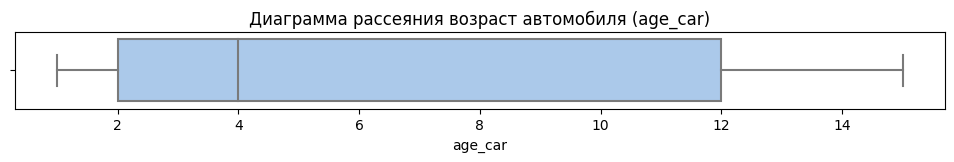

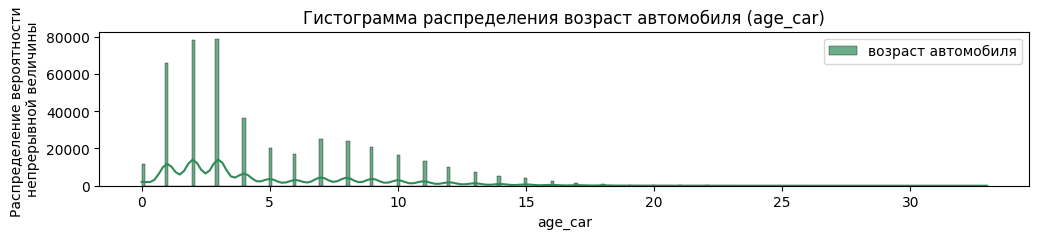

In [ ]:
feed_size(data_train3, 'age_car', 'возраст автомобиля')

### **Анализ получившегося датасета.**

In [ ]:
#data_test3.info()

In [ ]:
#напишем функию для исследования данных
def research1(data, name, figsize, silent):
    print(f'Размер данных:      {data.shape}')
    if not silent:
        print(f'Количество явных дубликатов: {data.duplicated().sum()}')
        print(f'Наличие пропусков:           {data.isna().sum().sum()}')
        data.info()
    if silent:
        data.columns
        #тепловая карта корреляций
        phik_overview = data.phik_matrix()
        plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Pastel2",
                        title=f"Корреляция {name} $\phi_K$",
                        fontsize_factor=1,
                        figsize=(12, 7))
        plt.tight_layout()
    print()
    if not silent:
        #print(f'\nПроверка структуры {name}:')
        data.hist(linewidth=2, histtype='step', figsize=figsize) #
        plt.suptitle(f'Гистограмма распеределения {name}', y=0.94, fontsize=12)
        plt.show()
        print()
        display(data.sample(3))
        display(data.describe())

In [ ]:
#создадим тестовый датасет на проверку корреляции между признаками
data_train_5000 =data_train3.copy().sample(5000)

Размер данных:      (5000, 17)
interval columns not set, guessing: ['year', 'condition', 'odometer', 'sellingprice', 'year_sale', 'month_sale', 'age_car']


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x787d63bf4940>


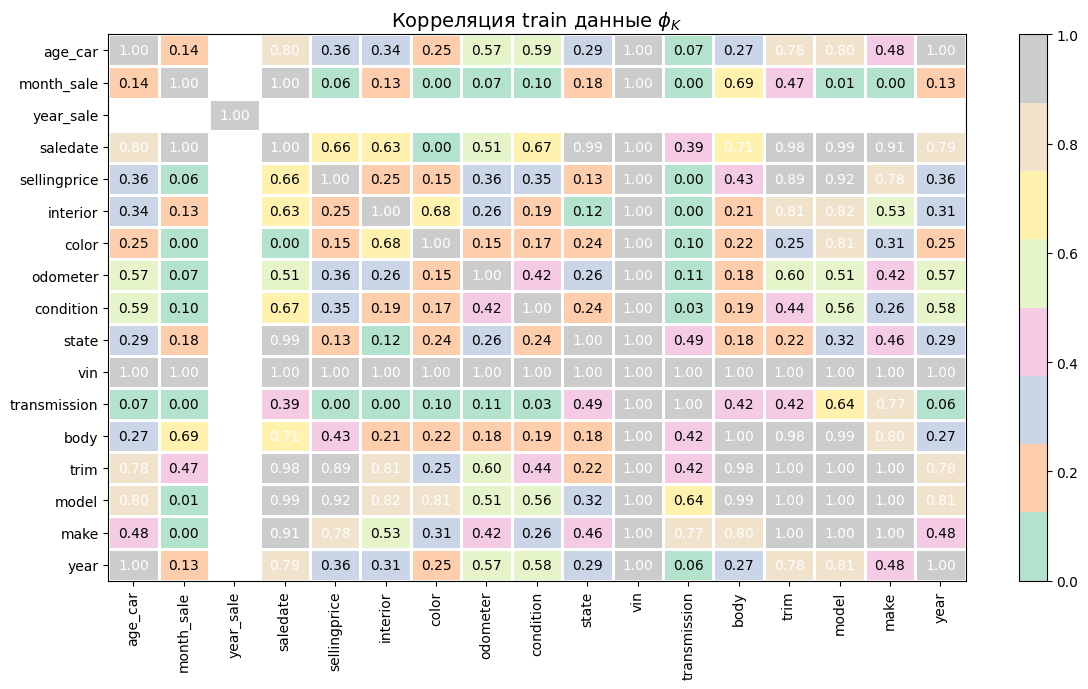

In [ ]:
research1(data_train_5000, "train данныe", figsize=(15, 8), silent=True) #

In [ ]:
data_test_5000 =data_test3.copy().sample(5000)
research1(data_test_5000, "test данныe", figsize=(15, 8), silent=True)

### **Удаление неинформативных признаков**

In [ ]:
#удаляем данные с высокой корреляцией
data_train_5000 = data_train_5000.drop(['year_sale', 'year', 'body','make', 'interior', 'saledate', 'trim'], axis=1)
data_train_5000.columns

Index(['model', 'transmission', 'vin', 'state', 'condition', 'odometer',
       'color', 'sellingprice', 'month_sale', 'age_car'],
      dtype='object')

Размер данных:      (10000, 11)
interval columns not set, guessing: ['condition', 'odometer', 'sellingprice', 'month_sale', 'age_car']


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7c42869fd960>



CPU times: user 2.89 s, sys: 630 ms, total: 3.52 s
Wall time: 5min 11s


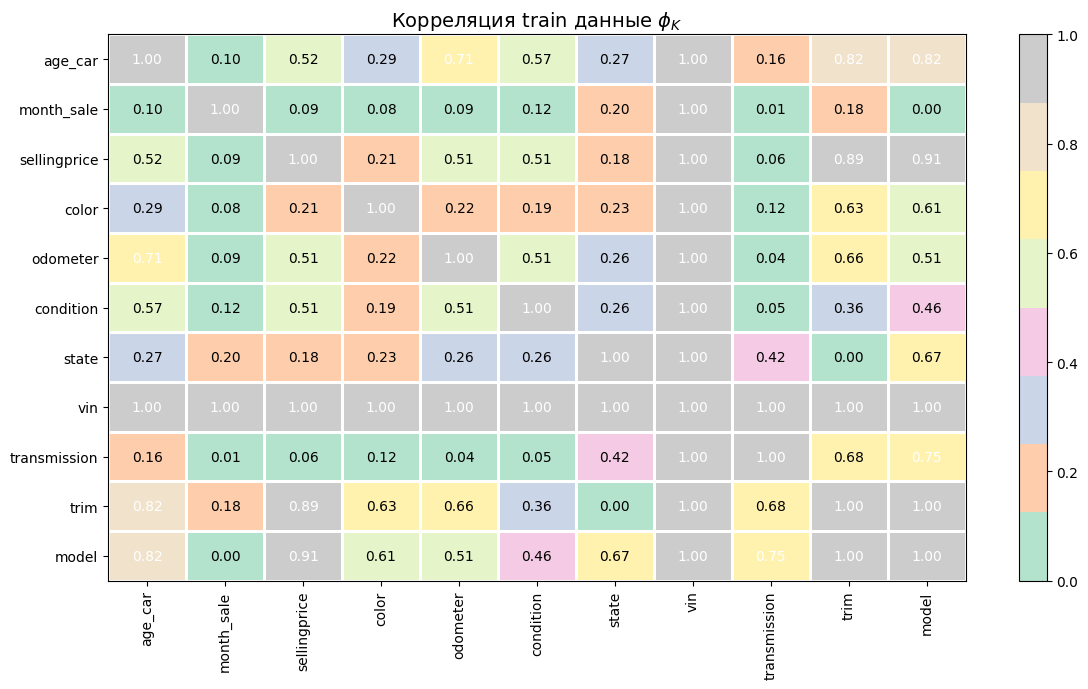

In [ ]:
%%time
research1(data_train_5000, "train данныe", figsize=(15, 8), silent=True)

In [ ]:
#удалим признаки из основного датасета (train и test)
#удаляем данные с высокой корреляцией
data_train3 = data_train3.drop(['year_sale', 'year', 'body','make', 'interior', 'saledate', 'trim'], axis=1)
data_test3 = data_test3.drop(['year_sale', 'year', 'body','make', 'interior', 'saledate', 'trim'], axis=1)
print(data_train3.columns)
data_test3.columns

Index(['model', 'transmission', 'vin', 'state', 'condition', 'odometer',
       'color', 'month_sale', 'age_car'],
      dtype='object')

Размер данных:      (440236, 10)
Количество явных дубликатов: 0
Наличие пропусков:           0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   model         440236 non-null  object 
 1   transmission  440236 non-null  object 
 2   vin           440236 non-null  object 
 3   state         440236 non-null  object 
 4   condition     440236 non-null  float64
 5   odometer      440236 non-null  float64
 6   color         440236 non-null  object 
 7   sellingprice  440236 non-null  int64  
 8   month_sale    440236 non-null  int64  
 9   age_car       440236 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 33.6+ MB



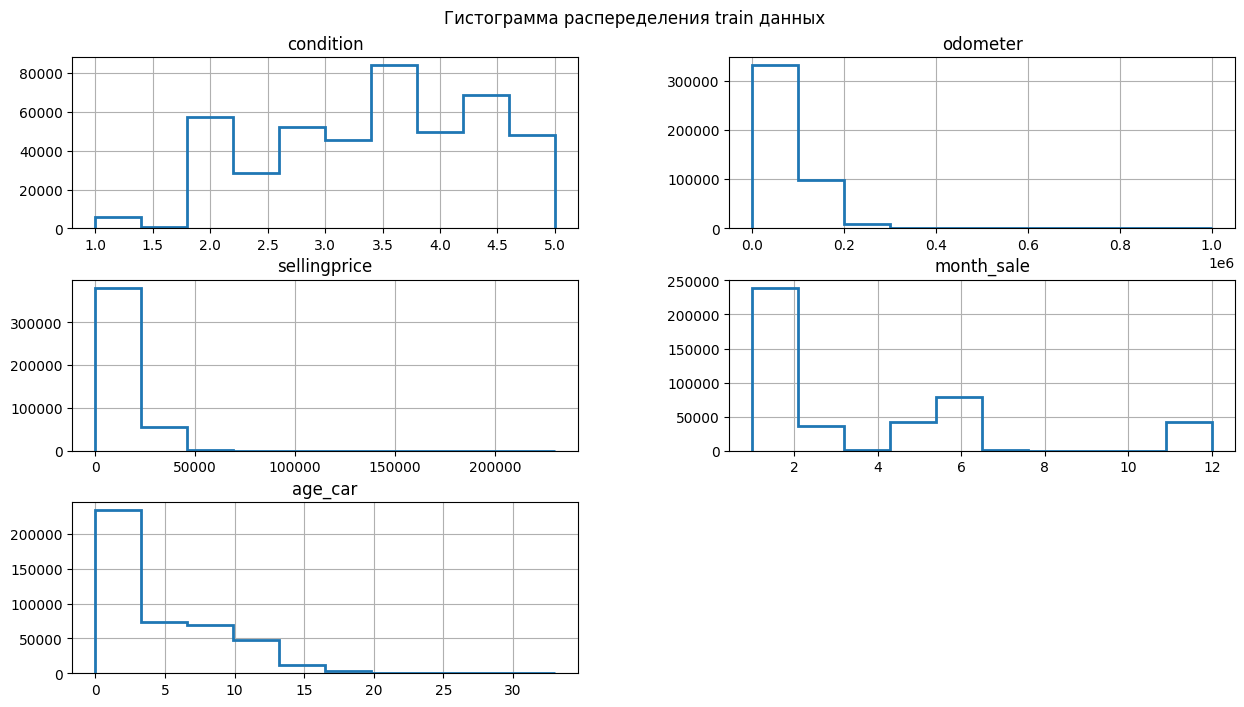

,model,transmission,vin,state,condition,odometer,color,sellingprice,month_sale,age_car
45205,ION,automatic,1G8AJ55F16Z202436,ne,3.9,96866.0,silver,3000,1,9
177653,Versa,automatic,3N1CN7AP2EL856254,ca,4.4,3018.0,blue,12750,2,1
213925,Impala Limited,automatic,2G1WC5E37E1112476,tn,4.4,25358.0,black,15000,5,1


,condition,odometer,sellingprice,month_sale,age_car
count,440236.000000,440236.000000,440236.000000,440236.000000,440236.000000
mean,3.428814,68344.421604,13592.209588,3.816028,4.863164
std,0.940111,53538.007789,9751.479098,3.244866,3.953459
min,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.700000,28260.000000,6900.000000,1.000000,2.000000
50%,3.600000,52106.000000,12100.000000,2.000000,3.000000
75%,4.200000,99266.000000,18200.000000,6.000000,7.000000
max,5.000000,999999.000000,230000.000000,12.000000,33.000000


Размер данных:      (110058, 9)
Количество явных дубликатов: 0
Наличие пропусков:           0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   model         110058 non-null  object 
 1   transmission  110058 non-null  object 
 2   vin           110058 non-null  object 
 3   state         110058 non-null  object 
 4   condition     110058 non-null  float64
 5   odometer      110058 non-null  float64
 6   color         110058 non-null  object 
 7   month_sale    110058 non-null  int64  
 8   age_car       110058 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 7.6+ MB



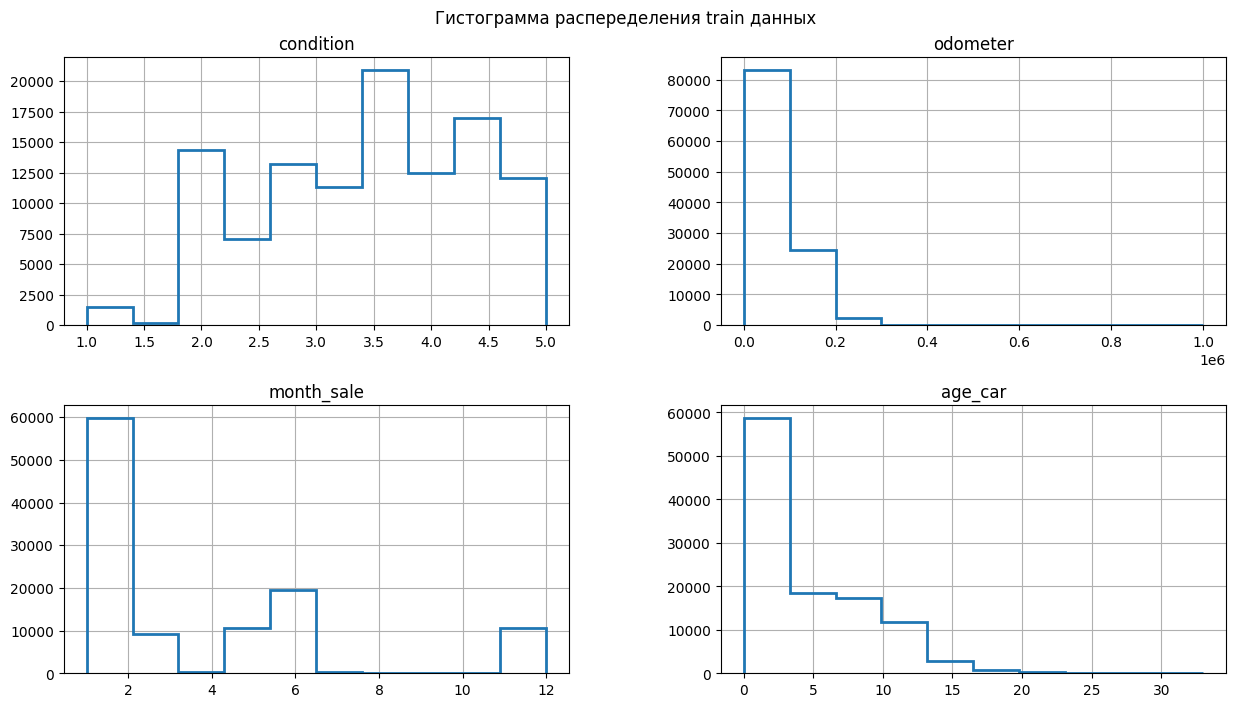

,model,transmission,vin,state,condition,odometer,color,month_sale,age_car
70434,Fusion,automatic,3FA6P0H78ER221141,mo,4.4,26996.0,green,2,1
55416,Mazda6,automatic,1YVHZ8BH1B5M27603,fl,3.5,84360.0,silver,2,4
60718,Edge,automatic,2FMDK39C38BA11395,mo,2.0,86141.0,blue,1,7


,condition,odometer,month_sale,age_car
count,110058.000000,110058.000000,110058.000000,110058.000000
mean,3.427043,68074.331601,3.809046,4.843383
std,0.941314,53516.368101,3.241122,3.937747
min,1.000000,1.000000,1.000000,0.000000
25%,2.700000,28317.000000,1.000000,2.000000
50%,3.600000,51935.000000,2.000000,3.000000
75%,4.200000,98846.500000,6.000000,7.000000
max,5.000000,999999.000000,12.000000,33.000000


CPU times: user 2.28 s, sys: 200 ms, total: 2.48 s
Wall time: 2.29 s


In [ ]:
%%time
research1(data_train3, "train данных", figsize=(15, 8), silent=False)
research1(data_test3, "train данных", figsize=(15, 8), silent=False)

###**Переведем категориальные типы данных в `category`, для более удобных расчетов в посроении моделей**

In [ ]:
#Сохраним полученные данные
#data_train3.to_csv('data_train5.csv', index=False)
#data_test3.to_csv('data_test5.csv', index=False)

In [ ]:
data_train3=pd.read_csv('/content/data_train5.csv')
data_test3=pd.read_csv('/content/data_test5.csv')

In [ ]:
#переведем категориальные данные в category типы данных, для более удобных расчетов в посроении моделей
def change_cat(data):
    row_cat = ['model', 'transmission', 'vin', 'state', 'color']
    #data[row_float] = data[row_float].apply(lambda x: pd.to_numeric(x, errors='coerce').astype('float64'))
    data[row_cat] = data[row_cat].astype('category')

In [ ]:
change_cat(data_train3)
change_cat(data_test3)
print(data_train3.info())
data_train3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   model         440236 non-null  category
 1   transmission  440236 non-null  category
 2   vin           440236 non-null  category
 3   state         440236 non-null  category
 4   condition     440236 non-null  float64 
 5   odometer      440236 non-null  float64 
 6   color         440236 non-null  category
 7   sellingprice  440236 non-null  int64   
 8   month_sale    440236 non-null  int64   
 9   age_car       440236 non-null  int64   
dtypes: category(5), float64(2), int64(3)
memory usage: 40.1 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   model         440236 non-null  category
 1   transmission  440236 non-null

**Выводы:**
- Проверила признаки на коллинеарность, удалила слудующие признаки: `'year_sale', 'year', 'body','make', 'interior', 'saledate', 'trim'`
- Перевела данные с типом `object` в тип `category`, для более удобных дальнейших вычислений.

### **Разделение общего датасета на выборки для обучения и проверки модели.**

In [ ]:
#входящие данные
random_state = 12345
cv_counts = 5
features = data_train3.drop('sellingprice', axis=1)
target = data_train3['sellingprice']

In [ ]:
features_train, features_val, target_train, target_test = train_test_split(
                                                            features, target,
                                                            test_size=0.057301, random_state=random_state)
features_test = data_test3.copy()
#Проверим размеры выборок:
for i in [features_train, target_train, features_val, target_test, features_test]:
    print(i.shape)

(415010, 9)
(415010,)
(25226, 9)
(25226,)
(25226, 9)


### **Кодирование и масштабирование признаков - стандартизация данных, по необходимости.**
Так как у нас присутствуют категориальные признаки, применим методы OE и OHE для кодирования.

Так как у нас разные модели, то используем разные методы кодирования.
Для линейной модели используем метод прямого кодирования ОНЕ

In [ ]:
#категориальные признаки
cat_features = features_train.select_dtypes(include='category').columns.to_list()
print(cat_features)
#численные признаки
num_features = features_train.select_dtypes(exclude='category').columns.to_list()
num_features

['model', 'transmission', 'vin', 'state', 'color']


['condition', 'odometer', 'month_sale', 'age_car']

In [ ]:
#для модели нелинейных моделей, в частности GBMRegressor
#Преобразуем категориальные признаки в численные с помощью техники порядкового кодирования OE
#encoder = OrdinalEncoder( dtype=np.int16, handle_unknown='use_encoded_value', unknown_value=-1)
encoder = OrdinalEncoder(dtype=np.int16, handle_unknown='use_encoded_value', unknown_value=-1, encoded_missing_value=-2)
features_train_oe = features_train[cat_features]
encoder.fit(features_train[cat_features])
features_train_oe[cat_features] = encoder.transform(features_train[cat_features]).astype(np.int16)
encoder = OrdinalEncoder(dtype=np.int16, handle_unknown='use_encoded_value', unknown_value=-1, encoded_missing_value=-2)

features_test_oe = features_test[cat_features]
features_val_oe = features_val[cat_features]
encoder.fit(features_test[cat_features])
encoder.fit(features_val[cat_features])
features_test_oe[cat_features] = encoder.transform(features_test[cat_features]).astype(np.int16)
features_val_oe[cat_features] = encoder.transform(features_val[cat_features]).astype(np.int16)
print('Закодированные методом OE данные')
display(features_train_oe.head(3))
display(features_test_oe.head(3))

Закодированные методом OE данные


,model,transmission,vin,state,color
179228,274,0,-23329,15,14
75802,640,0,23383,15,6
432382,360,0,-23361,26,18


,model,transmission,vin,state,color
0,104,0,-1,3,15
1,502,0,-1,27,18
2,389,0,-1,24,7


In [ ]:
features_train_ohe = features_train.copy()
features_test_ohe = features_val.copy()
#features = features.astype(np.int8).toarray()

In [ ]:
#запускаем энкодер и обучаем выборки
#encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
#encoder_ohe.fit(features_train_ohe[cat_features])
#features_train_ohe[encoder_ohe.get_feature_names_out()] = \
#                        encoder_ohe.transform(features_train_ohe[cat_features])
#features_train_ohe = features_train.drop(cat_features, axis=1)

#features_test_ohe[encoder_ohe.get_feature_names_out()] = \
#                        encoder_ohe.transform(features_test_ohe[cat_features])
#features_test_ohe = features_val.drop(cat_features, axis=1)
#print('Закодированные методом OHE данные')
#display(features_train_ohe.head(2))
#display(features_test_ohe.head(2))


In [ ]:
# стандартизируем данные ohe
#features_train_ohe_sc = features_train_ohe.copy()
#features_test_ohe_sc = features_test_ohe.copy()
#scaler = StandardScaler()
#features_train_ohe_sc[num_features] = scaler.fit_transform(features_train[num_features]) #train
#features_test_ohe_sc[num_features] = scaler.transform(features_test_ohe_sc[num_features])#тестовую
#print('Закодированные методом OHE стандартизированные данные')
#display(features_train_ohe_sc.head(2))
#display(features_test_ohe_sc.head(2))

**Выводы:**
- Проверила признаки на коллинеарность, удалила слудующие признаки: `'year_sale', 'year', 'body','make', 'interior', 'saledate', 'trim'.
- Разделила датасет train в необходимой пропорции.
- применила метод кодирования: OE
- отказалась от идеи кодирования методом OHE - не хватает ресурсов, либо надо более детально прредобрабатывать данные

## **4. Обучение моделей**

### **Описание моделей:**

У нас задача регрессии, начит будем рассматривать линейные и нелинейные модели регресии. Будем идти от большего к меньшему.

- **Линейные модели**:
  - **Линейная регрессия** и **Lasso**:
Так как у нас есть признаки, которые сильно коррелируют между собой (я не удалила базовую стоимость), поэтому чтобы избежать мультиколлинеарности используем линейную регресию **Lasso**.
Проведем кроссвалидацию и подтвердим, либо опровергнем мою гипотезу.

- **Модели деревьев - DecisionTreeRegressor**:

- **Нелинейные модели, работающие по алгоритму градиентного бустинга**: **CatBoostRegressor, XGBRegressor**

Будем использовать **pipeline** вместе с кросс-валидацией ( методами **GridSearchCV** и **RandomSearchCV**). Это позволит кодировать и масштабировать отдельно каждую тренировочную и валидационную выборки внутри кросс-валидации (без «подглядывания»).

### **Проведем предвартельную проверку моделей**

In [ ]:
models = []
models.append(('LR', LinearRegression()))
models.append(('Lasso', Lasso()))
models.append(('DT', DecisionTreeRegressor(random_state = random_state)))
#models.append(('RF', RandomForestRegressor(random_state = random_state)))
models.append(('CatBoostR', CatBoostRegressor(random_state = random_state, verbose=False)))
#models.append(('LGBMR', LGBMRegressor(random_state = random_state)))3
models.append(('XGBR', XGBRegressor(random_state = random_state)))

def cvs (models, features_train, target_train):

    # запускаем расчет моделей в цикле
    results = []
    names = []
    for name, model in models:
        cv_mae = (cross_val_score(model,features_train,
                                 target_train, cv=5,
                                 scoring= 'neg_mean_absolute_percentage_error').mean() * -1)
        results.append(cv_mae)
        names.append(name)
        print('MAPE %s:  %f ' % (name, cv_mae.mean()))#(%f)

    return results, names

In [ ]:
%%time
#Закодированные методом ОЕ
results_oe, names_oe = cvs (models, features_train_oe, target_train)

MAPE LR:  1.849332 
MAPE Lasso:  1.849430 
MAPE DT:  0.392736 
MAPE CatBoostR:  0.875920 
MAPE XGBR:  0.777806 
CPU times: user 12min 42s, sys: 14.4 s, total: 12min 56s
Wall time: 9min 50s


**Вывод:**
- Проверка кросс-валидации показала, лучшие результаты дают нелинейные модели, что в принципе объяснимо, так как у нас метод кодирования OE:
  - лучшая - дерево решений **DecisionTreeRegressor**:
    - **MAPE DT:  0.393**
  - бустинговые модели тоже показали себя неплохо, лучшая из них **XGBR** но значительно хуже дерева решений:
    - **MAPE XGBR:  0.778**
    - MAPE CatBoostR:  0.876

### **Обучение моделей**
Приступим непосредственно к обучению:
- уберем модели, котрые дали результат хуже, оставим 3 шт., чтобы не перегружать проект.
- используем **pipeline**, перебор методом **RandomSearchCV**

In [ ]:
# Вводим переменные
model_2 = DecisionTreeRegressor()
model_3 = CatBoostRegressor(random_state = random_state, verbose=False)
model_5 = XGBRegressor(random_state = random_state)

In [ ]:
%%time
# Инициируем гиперпараметры для рассматриваемых моделях
param2 = {}
param2['regression__max_depth'] = [i for i in range(1,20)]
#param2['regression__class_weight'] = [None, 'balanced']
param2['regression'] = [model_2]

param3 = {}
param3['regression__learning_rate'] = [i/10 for i in range(1, 6)]
param3['regression__n_estimators'] = [50, 100, 10]
param3['regression__loss_function'] = ['MAPE']
param3['regression__max_depth'] = [i for i in range(5,10)]
param3['regression__class_weight'] = [None, 'balanced']
param3['regression'] = [model_3]

param5 = {}
param5['regression__learning_rate'] = [i/100 for i in range(1, 50)]
#param5['regression__silent'] = [True]
param5['regression'] = [model_5]

CPU times: user 31 µs, sys: 0 ns, total: 31 µs
Wall time: 36 µs


In [ ]:
%%time
pipeline = Pipeline([('regression', model_2)])
params = [param2, param3, param5] #param1,, param4

CPU times: user 24 µs, sys: 0 ns, total: 24 µs
Wall time: 29.1 µs


### **Randomized Search CV**

In [ ]:
%%time
start = time.time()
rs = RandomizedSearchCV(pipeline, params, cv=5, n_jobs=-1, scoring='neg_mean_absolute_percentage_error').fit(features_train_oe, target_train)
end = time.time()
t_rs=round(end-start,2)

CPU times: user 9.05 s, sys: 1.45 s, total: 10.5 s
Wall time: 10min 31s


In [ ]:
# Гиперпараметры лучшей модели на RandomizedSearchCV
rs.best_params_

{'regression__max_depth': 17,
 'regression': DecisionTreeRegressor(max_depth=17)}

In [ ]:
# MAPE для лучшей модели
mape_rs = - rs.best_score_
print(f'Cреднее абсолютное отклонение в процентах (МАПД) лучшей модели, \
найденной методом RandomSCV MAPE_train = {round(mape_rs, 2)}')

Cреднее абсолютное отклонение в процентах (МАПД) лучшей модели, найденной методом RandomSCV MAPE_train = 0.49


## 4. **Проверка лучшей модели на тестовой выборке**


#### Тестовой выборке - полученной из train.

In [ ]:
# Прогноз на тестовых данных
pred_val = rs.predict(features_val_oe)
# Вычисляем MAPE
mape_val = mean_absolute_percentage_error(target_test, pred_val)
print(f"Тестовая из train MAPE: {round(mape_val, 2)}")

Тестовая из train MAPE: 2.84


In [ ]:
#mape_val_rs = mean_absolute_percentage_error(rs.predict(features_val_oe), target_test)
#print(f'Cреднее абсолютное отклонение в процентах (МАПД) лучшей модели,найденной методом RandomizedSearchCV MAPE_test = {round(mape_val_rs, 2)}')

Cреднее абсолютное отклонение в процентах (МАПД) лучшей модели, найденной методом RandomizedSearchCV MAPE_test = 3.49


#### Проверяем работу модели на внешней тестовой выборке:

In [ ]:
# Прогноз на тестовых данных
pred_test = rs.predict(features_test_oe)
# Вычисляем MAPE
mape_test = mean_absolute_percentage_error(target_test, pred_test)
print(f"Тестовая MAPE: {round(mape_test, 2)}")

Тестовая MAPE: 2.62


In [ ]:
pred_test

array([25800.,   450., 36000., ...,   375.,   895.,  3750.])

### **Исследование значимости признаков лучшей модели**

In [ ]:
%%time
#найдем признаки лучшей модели полученной методом RandomSCV
start = time.time()
#gs_importances = gs.fit(features_train_scale, target_train)
feature_importances_rs = rs.best_estimator_._final_estimator.feature_importances_
feature_importances_rs
end = time.time()
t_rs=round(end-start,2)

CPU times: user 2.41 ms, sys: 0 ns, total: 2.41 ms
Wall time: 9.29 ms


In [ ]:
def graph_features (model, features, name):
    feature_importance = pd.DataFrame((model), list(features.columns),columns=['Значения'])\
                                        .reset_index().rename(columns={'index':'Признаки'})
    plt.figure(figsize=(10, 3))
    sns.barplot(x="Значения", y="Признаки", data=feature_importance.sort_values(by="Значения", ascending=False), palette = 'tab20')#'Pastel2','rainbow'
    plt.title(f'Оценка важности признаков {name}')
    plt.tight_layout()
    plt.show()

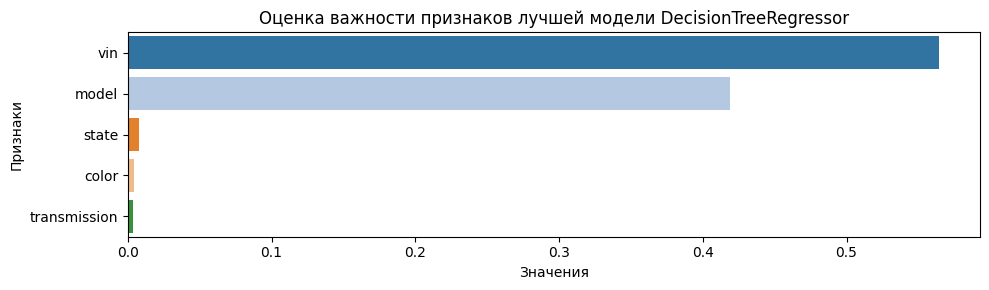

In [ ]:
graph_features (feature_importances_rs, features_test_oe, 'лучшей модели DecisionTreeRegressor')

# **Предсказываем цены на автомобили с помощью нашей модели:**

In [ ]:
def predict_price(condition, odometer, age_car):
    # Создание массива с параметрами квартиры
    features = [[condition, odometer, age_car]]
    # Выполнение предсказания с использованием обученной модели gs
    predicted_price = rs.predict(features)

    return predicted_price[0]

In [ ]:
формирование списка предсказанной цены
predicted_prices = data_test3.apply(lambda row: predict_price(row['condition'], row['odometer'],\
                                                         row['age_car']), axis=1).tolist()


##! **НУЖНА ПОМОЩЬ и ВРЕМЯ**
### не получается вывести данные в нужном формате - надо чуть больше времени. Я ж так понимаю, надо предсказанные данные выводить

In [ ]:
#predicted_price = predict_price(data_test3['condition'][10], data_test3['odometer'][10], data_test3['age_car'][10])
#predicted_price

In [ ]:
#data_test3.loc[10],data_test3.loc[18],data_test3.loc[66]

In [ ]:
# В процессе доработки
#формирование списка предсказанной цены
#predicted_prices = data_test3.apply(lambda row: predict_price(row['condition'], row['odometer'],\
#                                                         row['age_car']), axis=1).tolist() #row['vin'],

#plt.scatter(data_test3['price_m2'], predicted_prices)
#plt.xlabel('Актуальная цена')
#plt.ylabel('Предсказанная цена')
#plt.title('Актуальные и предсказанные цены')
#x = data_test3['price_m2']
#y = np.array([a for a in x])
#plt.plot(x, y, color='red', linestyle='--', label='Биссектриса')
#plt.show()

# **Вывод:**
- Были загружены и исследованы сырые данные по продажам машин.
  - было выявлено пропусков 12% в `transmission` и 2% в  `make, model,trim, body, condition`.
  - явных аномалий не наблюдалось
  - явных дубликатов также не выявлено, нужно копнуть глубже для улучшения показателей в будущем.
  - наблюдаеется некоторая сезонность: если смотреть по датам продаж, видно, что наиболее активные продажи наблюдаются в январе и июне.
- Предобработка датасета:
  - были заполнены некототорые пропуски make и model заполнила из VIN.
  - transmission - бинарные значения заполнила их ориентируясь на год, модель и кем изготовлена - по вероятности.
  - с использованием mean
  - на остальные поставила заглушку.
-  При анализ данных и подготовке данных для построения модели:
  - Создала новые признаки  `year_sale`, `month_sale` и `age_car`.
  - в дальнейшем проверила модель на коллинеарность признаков: при значении `phik>0.81` удалила `'year_sale', 'year', 'body','make', 'interior', 'saledate', 'trim'`.
  - Перевела данные с типом `object` в тип `category`, для более удобных дальнейших вычислений.
- Обучение проводила от по принципу от простого к сложному:
   - Взяла **Линейные модели**: **Линейная регрессия** и **Lasso**:
   -  Нелинейные модели,деревья - **DecisionTreeRegressor**:
   - Затем нелинейные модели, работающие по алгоритму градиентного бустинга: **CatBoostRegressor и XGBRegressor**
- Запустила сначала кросс-валидацию, для первичной оценке работы моделей - по итогу отобрала лучшие 3: **DecisionTreeRegressor**,**CatBoostRegressor и XGBRegressor**.
   - Лучшей из них оказалась: дерево решений **DecisionTreeRegressor* - MAPE DT:  0.393**
- При обучении модели использовала **pipeline** вместе с методом **RandomSearchCV**.
- В результате получила лучшую модель:
  - **DecisionTreeRegressor(max_depth=17)**
  - Cреднее абсолютное отклонение в процентах (МАПД) лучшей модели **MAPE_train = 0.49**
- Проверила модель на тестовой выбокрке,
  - полученной из основного датасета:
  > Тестовая из train MAPE: 2.84
  - из тестового датасета (который дали по условию задачи):
  > **Тестовая MAPE: 2.62**
- Результат показал, что модель требует доработки - данные на порядок хуже.
- Также оценка важности признаков показала, что основными признакам по важности в обучении нашей модели являются VIN и model.  Хотя по логике на формирование цены должны оказывать важное влияние такие признаки, как odometer и age_car. Данные разультаты также указывают на необходимость доработки модели.
- В чем я вижу возможность улучшения модели:
  - во-первых необходимо чуть более глубоко поработать с неявными признаками. Чуть лучше почистить от шумов данные.
  - это также позволит уменьшить нагрузку на ОЗУ и, возможно удастся поработать с закодированными признаками по методу OHE - сейчас пришлось отказаться от этой идеи, ресурсы не позволили.
  - также надо попробовать промасштабировать данные - протестить результат.
  - можно будет отсортировать: механика -автомат (1- дешевле, 2-дороже)
  - можно разделить на категории: дорогая, средний класс, дешевая (можо для теста использовать, обучать по каждому классу)
  - сформировать синтетические признаки: пробег/срок жизни машины, средний пробег за день, кластеризация, состояние авто: старая, новая (из года выпуска, пробега)
  - попробовать построить отдельную модель по дороговизне, прогнать по другой модели, также попробовать с данными по пропусками марки и модели.
  - после буду смотреть, как можно еще докрутить модель. работы море уже.

# **ПОМОГИТЕ**
Попыталась загрузить модель в базу данных,
запустила REST API. На вход модели подаю параметры в формате JSON на выходе должна получаться цена авто в формате JSON:
 - почему в обоих случаях, он запускается - но не работает?
 Не знаю уже куда смотреть

In [ ]:
#В процессе доработки
import json
from flask import Flask, request
!pip install flask
!pip install flask-ngrok
from flask_ngrok import run_with_ngrok

app = Flask(__name__)
run_with_ngrok(app)

# Load the model and make predictions
def predict_price(condition, odometer, age_car):
    features = [[condition, odometer, age_car]]
    predicted_price = rs.predict(features)

    return predicted_price[0]

# Route for getting predictions
@app.route('/predict', methods=['POST'])
def get_prediction():
    data = request.get_json()
    condition = data['condition']
    odometer = data['odometer']
    age_car = data['age_car']
    result = predict_price(condition, odometer, age_car)
    return json.dumps(result)


if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): bin.equinox.io:443
DEBUG:urllib3.connectionpool:https://bin.equinox.io:443 "GET /c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip HTTP/1.1" 200 13921656
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): localhost:4040
DEBUG:urllib3.connectionpool:http://localhost:4040 "GET /api/tunnels HTTP/1.1" 200 789


 * Running on http://b33d-34-23-167-75.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


In [ ]:
#В процессе доработки
import json
from flask import Flask, request
!pip install flask
!pip install flask-ngrok
!pip install gunicorn
from flask_ngrok import run_with_ngrok
!gunicorn -w 4 your_app:app

app = Flask(__name__)
#run_with_ngrok(app)

app = Flask(__name__)
run_with_ngrok(app)

# Load the model and make predictions
def predict_price(condition, odometer, age_car):
    features = [[condition, odometer, age_car]]
    predicted_price = rs.predict(features)

    return predicted_price[0]

# Route for getting predictions
@app.route('/predict', methods=['POST'])
def get_prediction():
    data = request.get_json()
    condition = data['condition']
    odometer = data['odometer']
    age_car = data['age_car']
    result = predict_price(condition, odometer, age_car)
    return json.dumps(result)


if __name__ == '__main__':
    # Run the app using Gunicorn server
    # Install Gunicorn:
    !pip install gunicorn
    # Start the server:
    !gunicorn -w 4 your_module:app -b 127.0.0.1:5000
    app.run()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 1.1 MB/s eta 0:00:00
[2023-09-01 20:09:23 +0000] [38629] [INFO] Starting gunicorn 21.2.0
[2023-09-01 20:09:23 +0000] [38629] [INFO] Listening at: http://127.0.0.1:8000 (38629)
[2023-09-01 20:09:23 +0000] [38629] [INFO] Using worker: sync
[2023-09-01 20:09:23 +0000] [38630] [INFO] Booting worker with pid: 38630
[2023-09-01 20:09:23 +0000] [38630] [ERROR] Exception in worker process
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gunicorn/arbiter.py", line 609, in spawn_worker
    worker.init_process()
  File "/usr/local/lib/python3.10/dist-packages/gunicorn/workers/base.py", line 134, in init_process
    self.load_wsgi()
  File "/usr/local/lib/python3.10/dist-packages/gunicorn/workers/base.py", line 146, in load_wsgi
    self.wsgi = self.app.wsgi()
  File "/usr/local/lib/python3.10/dist-packages/gunicorn/app/base.py", line 67, in wsgi
    self.callable = self.load()
  File "/usr/local/lib/pytho

INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): localhost:4040
DEBUG:urllib3.connectionpool:http://localhost:4040 "GET /api/tunnels HTTP/1.1" 200 789


 * Running on http://fde7-34-23-167-75.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040
